# Photon Propagation

There are two main ways to propagate electromagenetic particle (EM particles: photons, electrons, positrons) in CRPropa.
1) propagation as part of the CRPropa simulation chain
2) propagation outside of the CRPropa simulation chain

The following describes option 2, for which CRPropa provides three functions.
EM particles can be either propagated individually using the external EleCa code (suitable for high energies), or their spectra can be propapagated with the transport code DINT (suitable for low energies).
Alternatively a combined option is available that processes high energy photons with Eleca and the calculates the resulting spectra with DINT down to low energies.

All three functions take as input a plain-text file with EM particles in `PhotonOutput1D` format.
In the following examples the input file "photon_monoenergetic_source.dat" contains 1000 photons with E = 50 EeV from a photon source in 4 Mpc distance.

The last example "Photons from Proton Propagation" shows how to obtain secondary EM particles from a simulation of hadronic cosmic rays.

Note that the differing results in EleCa (and correspondingly the high energy part of the combined option) are due to an incorrect sampling of the background photon energies in EleCa. The EleCa support will be removed in the near future.



### Propagation with Eleca


In [1]:
import crpropa

# Signature: ElecaPropagation(inputfile, outputfile, showProgress=True, lowerEnergyThreshold=5*EeV, magneticFieldStrength=1*nG, background="ALL")
crpropa.ElecaPropagation("photon_monoenergetic_source.dat", "photons_eleca.dat", True, 0.1*crpropa.EeV, 0.1*crpropa.nG)



### Propagation with DINT


In [2]:
import crpropa

# Signature: DintPropagation(inputfile, outputfile, IRFlag=4, RadioFlag=4, magneticFieldStrength=1*nG, aCutcascade_Magfield=0)
crpropa.DintPropagation("photon_monoenergetic_source.dat", "spectrum_dint.dat", 4, 4, 0.1*crpropa.nG)



### Combined Propagation

In [3]:
import crpropa

# Signature: DintElecaPropagation(inputfile, outputfile, showProgress=True, crossOverEnergy=0.5*EeV, magneticFieldStrength=1*nG, aCutcascade_Magfield=0)
crpropa.DintElecaPropagation("photon_monoenergetic_source.dat", "spectrum_dint_eleca.dat", True, 0.5*crpropa.EeV, 0.1*crpropa.nG)


### (Optional) Plotting of Results

-c:18: RuntimeWarning: invalid value encountered in divide


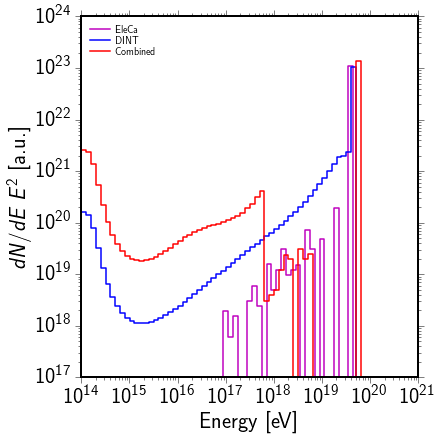

In [6]:
%matplotlib inline
from pylab import *

figure(figsize=(6,6))

loglog(clip_on=False)
yscale("log", nonposy='clip')
xlabel('Energy [eV]')
ylabel ('$dN/dE\; E^2$  [a.u.]')

# Plot the Eleca spectrum
elecaPhotons = genfromtxt("photons_eleca.dat")
binEdges = 10**arange(12, 24, .1)
logBinCenters = log10(binEdges[:-1]) + 0.5 * (log10(binEdges[1:]) - log10(binEdges[:-1]))
binWidths = (binEdges[1:] - binEdges[:-1])
data = histogram(elecaPhotons[:,1] * 1E18, bins=binEdges)
J = data[0] / binWidths
dJ = J / sqrt(data[0])
E = 10**logBinCenters
step(E, J * E**2,  c='m', label='EleCa')

#Plot the dint spectrum
data = genfromtxt("spectrum_dint.dat", names=True)
lE = data['logE']
E  = 10**lE
dE = 10**(lE + 0.05) - 10**(lE - 0.05)
J  = data['photons'] / dE
step(E, J * E**2 , c='b', ls='-', where='mid', label='DINT')

#Plot the combined dint+Eleca spectrum
data = genfromtxt("spectrum_dint_eleca.dat", names=True)
lE = data['logE']
E  = 10**lE
dE = 10**(lE + 0.05) - 10**(lE - 0.05)
J  = data['photons'] / dE
step(E, J * E**2 , c='r', ls='-', where='mid', label='Combined')

# Nice limits
xlim(1e14, 1E21)
ylim(ymin=1E17)
legend(loc='upper left')





## Photons from Proton Propagation

The generaton of photons has to be enabled for the individual energy-loss processes in the module chain. Also, a photon output module has to be added:

In [ ]:
from crpropa import *   

# source setup  
source = Source()       
source.add(SourceParticleType(nucleusId(1, 1))) 
source.add(SourcePowerLawSpectrum(10 * EeV, 100 * EeV, -2))     
source.add(SourceUniform1D(3 * Mpc, 100.00001 * Mpc))   

# setup module list for proton propagation
m = ModuleList()
m.add(SimplePropagation(0, 10 * Mpc))
m.add(MinimumEnergy(1 * EeV))

# observer
obs = Observer()
obs.add( ObserverPoint() )
obs.onDetection( TextOutput('proton_output.txt', Output.Event1D) )
m.add(obs)

# secondary electrons are disabled here
m.add(ElectronPairProduction(CMB, False))        
# enable secondary photons
m.add(PhotoPionProduction(CMB, True))   

# add a photon output
m.add(PhotonOutput1D("photon_output.txt"))

# run simulation        
m.run(source, 10000, True)

The file 'photon_output' will contain approximately 600 secondary particles, half of them photons and can be processed as the photon example above.